This notebook illustrates how to use Image2Function and some basic examples. First install and then import the necessary libraries and any dependencies. NOTe: parse_latex from Sympy 1.13.3 requires the antlr4-python3-runtime, specifically with version 4.11.0 and will not work with another version for antlr4. If you are using a different version of Sympy, the antlr4 version requirement may be different.

In [1]:
import copy
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import difflib
import gplearn
from gplearn.genetic import SymbolicRegressor
from joblib import dump, load
from sklearn.cluster import DBSCAN
import sympy as sp
from sympy.parsing.latex import parse_latex

Now set up generic directory variables, this will make reading files later easy to generalise, as well as the file_finder() function.

In [4]:
def get_script_dir():
    try:
        return os.path.abspath(__file__)
    except NameError:
        # Fallback: return the current working directory
        return os.getcwd()

scrip_dir = get_script_dir()  # gets the script directory or current working dir in notebooks
proj_dir = scrip_dir.replace(r'\Image2Function.ipynb', '')
print(f"proj_dir: {proj_dir}")


def file_checker(file_name, file_type):
    """
    This function verifies the existence of a given file name and its type within the project's structure. It can identify
    files based on their complete paths or search through the entire project directory for a match when only the file name
    and its type are provided. If no exact match is found, it suggests the closest potential match or raises an error if no
    similar files exist.

    :param file_name: The name of the file to be checked. It could be the complete file path or just the name
        without the path.
    :type file_name: str
    :param file_type: The expected file type(s) to filter files during the search process. This can be a single
        string representing the file extension, or a list of strings for multiple possible types.
    :type file_type: Union[str, list]
    :return: The full path of the found file if it matches the provided file name and file type.
    :rtype: str
    :raises FileNotFoundError: If the specified file is not found within the project directory. If the file name is not
        directly matched, a suggestion for the closest match is provided, or the error is raised indicating no similar
        files were found.
    """
    #in my case 'BPL Lab'
    # print(f"proj_dir: {proj_dir}")

    # Check if the file_name is already the full file path
    if os.path.isfile(file_name):
        print(f"Looking at file '{file_name}'.")
        return file_name #already done
    # If file_name is not a complete file path already
    try:
        all_files = []
        for root, dirs, files in os.walk(proj_dir): #gets all files in the project directory
            for file in files:
                all_files.append(os.path.join(root, file))
        # print(f"all_files: {all_files}")
    except FileNotFoundError:
        raise FileNotFoundError(f"The directory {proj_dir} does not exist.") #Should be impossible to happen but idk
    # Filter only files of the same type
    if type(file_type)==str:
        same_type_files = [file for file in all_files if file_type in str(file)]
    if type(file_type)==list:
        same_type_files = [file for file in all_files if any(ext in str(file) for ext in file_type)]
    # print(f"same_type_files: {same_type_files}")
    file_found=False
    for file in same_type_files:
        # print(file)
        curr_file_1=os.path.basename(file)
        curr_file_name, curr_file_extension = os.path.splitext(curr_file_1)
        # print(f"curr_file_name: {curr_file_name}")
        # print(f"curr_file_extension: {curr_file_extension}")
        if file_name==curr_file_name and 'tmp' not in curr_file_extension:
            file_found=True
            print(f"Looking at file '{file}'.")
            return file

    if file_found==False: #if no exact matches have been found look for suggestions.
        # Find the closest match using difflib
        same_type_files_base=[os.path.basename(file) for file in same_type_files]
        # print(f"same_type_files_base: {same_type_files_base}")
        closest_matches = difflib.get_close_matches(file_name, same_type_files_base, n=1, cutoff=0.6)
        # Raise FileNotFoundError with suggestion if a close match is found
        if closest_matches:
            suggestion = closest_matches[0]
            suggestion_name, suggestion_extension = os.path.splitext(suggestion)
            raise FileNotFoundError(
                f"The file '{file_name}' with file type {file_type} does not exist. Did you mean '{suggestion_name}' with file type '{suggestion_extension}'?"
            )
        else:
            # If no close matches are found, raise error without suggestion
            raise FileNotFoundError(f"The file '{file_name}' does not exist and no similar files were found.")

proj_dir: C:\Users\yagoi\Graduate Center Dropbox\Owen Root\Personal\College\12 Classes Spring 2025\Machine Learning\Final Project


Set up the function that reads the image of the plot.

In [7]:
def image_reader(input_image_location):
    """
    Reads an image from the specified location, processes the image to ensure it is
    square, and extracts pixel coordinates based on intensity thresholds. This
    function prepares the data for further image analysis or plotting.

    :param input_image_location: The file path to the input image.
    :type input_image_location: str
    :return: A list containing x-coordinates, y-coordinates, image width, image
        height, and the prepared image data for plotting.
    :rtype: list
    :raises ValueError: If the image is not square.
    """
    # handles different image extensions.
    exts = Image.registered_extensions()
    supported_extensions = [ex for ex, f in exts.items() if f in Image.OPEN]

    # gets the specified input image as an array of greyscale values.
    input_image_location = file_checker(input_image_location, supported_extensions)
    img = Image.open(input_image_location).convert('L')

    # creates an image object for plotting latter.
    img_for_plot=plt.imread(input_image_location)

    #acually makes the array.
    data = np.array(img)
    print(data)

    image_dim=data.shape
    if image_dim[0] != image_dim[1]:
        raise ValueError("Image must be square.")
    # print(f"image_dim[0]: {image_dim[0]}")
    # print(f"image_dim[1]: {image_dim[1]}")

    # if the image is mostly black (i.e. a chalk drawing on a black board),
    # invert the black and white
    # print(f'mean: {np.mean(data)}')
    if np.mean(data)<(255/2):
        # data=np.abs(data-255)
        data=np.absolute(255-data)

    #shift all the points in the array that are not a solid black line to white.
    data[data > 120] = 255 #120 seems to work in many cases, may need to be modified for some use cases.

    # moved the points from the 2D array to list of x and y values.
    x_vals=[]
    y_vals=[]
    for x in range(image_dim[0]):
        for y in range(image_dim[1]):
            if data[y,x] < 255 :
                x_vals.append(x)
                y_vals.append(y)

    #ensure dimensionality to original image is keep even if the drawn plot does not
    # extend through full domain or range.
    if len(x_vals)!= image_dim[0]:
        for i in range(image_dim[0]-len(x_vals)):
            x_vals.append(None)
    if len(y_vals)!= image_dim[1]:
        for i in range(image_dim[1]-len(y_vals)):
            y_vals.append(None)
    # print(f'x_vals: {x_vals}')
    # print(f'y_vals: {y_vals}')
    # print(len(x_vals))
    # print(len(y_vals))

    #convert from lists to arrays.
    x_vals=np.array(x_vals)
    y_vals=np.array(y_vals)

    #Flip the data to move the origin to the bottom left corner.
    mirror_axis = image_dim[1]/2
    y_vals=2*mirror_axis-y_vals

    return [x_vals, y_vals, image_dim[0], image_dim[1], img_for_plot]

Set up a fucntion that actually handles the symbolic regression fit through gplearns SymbolicRegressor(). Currently, some of the parameters of SymbolicRegressor() are hard coded to handle most generic use cases, but may need to be modifed to fit your needs. genetic_fitter() also has the option to save a fitted model as a file, so that it can be resued later without having to be trained again (by default the saving option is on). I recommend using the file extension '.joblib' for any saved model files, as the joblib library is what handle the model saving.

In [8]:
def genetic_fitter(x_vals, y_vals, x_domain=[0,1], y_range=[0,1], model_path=None,
                   use_saved=True):
    """
    Performs symbolic regression using a genetic programming approach to fit a given set
    of x and y values. Optionally loads a saved model if available or trains a new model
    and saves it. The method also returns a prediction based on the evolved expression.

    The parameters of SymbolicRegressor are left as hardcoded values, but they may need to be changed
    to fit the needs of the user.

    :param x_vals: Array-like object containing input feature data to be fitted.
    :param y_vals: Array-like object containing target values corresponding to x_vals.
    :param x_domain: A list representing the domain range [min, max] for the input values.
                      Default is [0, 1].
    :param y_range: A list representing the range of output values [min, max] the model might target.
                     Default is [0, 1].
    :param model_path: Optional relative path to a pre-trained model file. If not provided,
                       a default file location is used.
    :param use_saved: Boolean flag indicating whether to load a pre-trained model, if available.
                       Default is True.
    :return: A list containing predicted x values, predicted y values, and the best evolved
             expression (as a symbolic program object).
    """
    default_model_path=proj_dir+'\saved_model.joblib'
    if model_path==None:
        model_path=default_model_path
    else:
        model_path=proj_dir+r"\\"+model_path

    if use_saved and model_path and os.path.isfile(model_path):
        est_gp = load(model_path)
        print(f"Loaded pre-trained model from {model_path}")
    else:
        est_gp = SymbolicRegressor(
            population_size=1000,  # Number of candidate solutions in each generation
            generations=20,  # How many iterations (generations) to evolve
            tournament_size=20,  # Size of tournament for selecting individuals
            stopping_criteria=0.00001,  # Stop if error goes below this threshold
            const_range=(-100., 100.),  # Range for constant values in the expressions
            init_depth=(2, 6),  # Range for initial tree depths
            init_method='half and half',  # Method for generating the initial population
            function_set=['add', 'sub', 'mul', 'div', 'sqrt','sin', 'cos', 'tan'],  # Operators to use in expressions
                        #additional ones may need to be added for some use cases.
            metric='mean absolute error',  # Metric to optimize
            p_crossover=0.7,  # Crossover probability
            p_subtree_mutation=0.1,  # Subtree mutation probability
            p_hoist_mutation=0.05,  # Hoist mutation probability
            p_point_mutation=0.1,  # Point mutation probability
            verbose=1,  # Print progress during evolution
            parsimony_coefficient=0.02,  # Penalize overly complex expressions
            random_state=0,  # For reproducibility
            n_jobs=-1 #selects the number of cores to use for parallel processing. -1 uses all available cores.
        )

        #reshape the data for the genetic programming fit
        x_vals=x_vals.reshape(-1,1)
        est_gp.fit(x_vals, y_vals)

        if model_path:
            dump(est_gp, model_path)
            print(f"Saved trained model to {model_path}")

    print("Best evolved expression:", est_gp._program)
    # print(type(est_gp._program))

    x_vals_pred=np.linspace(x_domain[0],x_domain[1],1000)
    y_vals_pred = est_gp.predict(x_vals_pred.reshape(-1,1))

    return [x_vals_pred,y_vals_pred, est_gp._program]

Set up some functions to handle the conversion of latex formatted strings to computible functions and conversion of the SymbolicRegressor model to a latex formatted string. If any of the operator parameters of SymbolicRegressor above were modifed, there corresping Sympy operators will need to be added here as well.

In [9]:
def SymbRegg_to_latex(gp_prog):
    """
    Converts a gplearn._program._Program object representation of a symbolic
    regression expression into its corresponding LaTeX form.

    This function receives a `gplearn._program._Program` object, extracts its
    string representation, maps gplearn functions and terminals to Sympy
    equivalents, and finally converts the parsed expression into LaTeX format
    using Sympy's LaTeX functionality.

    :param gp_prog: A gplearn._program._Program object representing the
        symbolic regression program.
    :type gp_prog: gplearn._program._Program

    :return: A string containing the LaTeX representation of the symbolic
        regression expression.
    :rtype: str

    :raises TypeError: If the input is not of type `gplearn._program._Program`.
    """
    if type(gp_prog) != gplearn._program._Program:
        raise TypeError("Input must be a gplearn._program._Program object.")
    expr_str = str(gp_prog)
    x= sp.symbols('x')

    # Map gplearn functions and terminals to Sympy
    # Any addition operators added to genetic_fitter() will need to be added here as well.
    locals_dict = {
        'add': sp.Add,
        'mul': sp.Mul,
        'sub': lambda x, y: x - y,
        'div': lambda x, y: x / y,
        'sqrt': sp.sqrt,
        'log': sp.log,
        'X0': x,
        'sin': sp.sin,
        'cos': sp.cos,
        'tan': sp.tan,
        # 'x1': X1, 'x2': X2
    }

    # 5. Parse and convert to LaTeX
    sympy_expr = sp.sympify(expr_str, locals=locals_dict)
    latex_str = sp.latex(sympy_expr)

    print("LaTeX form:", latex_str)
    return latex_str

def Latex_to_function(latex_string, x_domain):
    """
    Converts a LaTeX string representation of a mathematical expression into a numerical
    function, evaluates it over a specified range of x-values, and returns the evaluated
    x and y values.

    This function takes in a LaTeX string, parses it into a symbolic expression, converts
    it into a numerical function, and computes the y-values over a specified domain of x-values.
    It also allows specifying an optional y-range for bounding the y-values.

    :param latex_string: A string containing the LaTeX representation of the
        mathematical expression.
    :type latex_string: str
    :param x_domain: A tuple specifying the start and end values of the x-domain
        over which the function should be evaluated (inclusive).
    :type x_domain: Tuple[float, float]

    :return: A list containing two elements - the first being an array of
        x-values evaluated over the specified domain, and the second being an
        array of the corresponding y-values.
    :rtype: List[numpy.ndarray]
    """
    x=sp.Symbol('x')
    expr=parse_latex(latex_string)
    f=sp.lambdify(x, expr, modules=['numpy'])
    x_values=np.linspace(x_domain[0],x_domain[1],1000)
    y_values=f(x_values)

    return [x_values, y_values]

Now finally, set up the function that brings it all together to read the data, execute the fit, and plot the results.

In [13]:
def image_fitter(input_image_location, x_domain=[0,1], y_range=[0,1], model_path=None,
                 use_saved=True, intd_expr=None, show_clusters=False, show_cluster_outliers=False,
                 show_image=True):
    """
    Performs image-based symbolic regression to fit a mathematical model to the input image data
    by removing outliers, performing clustering, and applying genetic programming techniques.

    :param input_image_location: Path to the input image file to be analyzed.
            #The image must be square.
    :type input_image_location: str
    :param x_domain: Domain range of the x-axis for scaling the input data,
        specified as a two-element list [x_min, x_max]. Default is [0,1].
    :type x_domain: list
    :param y_range: Domain range of the y-axis for scaling the input data,
        specified as a two-element list [y_min, y_max]. Default is [0,1].
    :type y_range: list
    :param model_path: Path to the folder or file for saving/loading models used for fitting.
        If None, no saving/loading is performed. Default is None.
    :type model_path: str or None
    :param use_saved: Boolean indicating whether to use a pre-saved model for the fitting process
        (if available) or perform fitting from scratch. Default is True.
    :type use_saved: bool
    :param intd_expr: Desired mathematical expression for the intended function as a string.
        If provided, the intended function will be plotted for comparison. Default is None.
    :type intd_expr: str or None
    :param show_clusters: Boolean indicating whether to plot clustered data after filtering out
        outliers. Default is False.
    :type show_clusters: bool
    :param show_cluster_outliers: Boolean indicating whether to plot clustered data with
        visible outliers. Default is False.
    :type show_cluster_outliers: bool
    :param show_image: Boolean indicating whether to display the input grayscale image
        in the plot. Default is True.
    :type show_image: bool
    :return: None
    """
    # read the image file.
    step1=image_reader(input_image_location)
    # step1 := [x_vals, y_vals, image_dim[0], image_dim[1], img_for_plot]
    x_vals=step1[0] # x coords, based on resolution of input image, will be rescaled later.
    y_vals=step1[1] # y coords, based on resolution of input image, will be rescaled late
    img_x_domain=step1[2] # x resolution size of image
    img_y_range=step1[3] # y resolution sizeof image
    img_for_plot=step1[4] # object for plotting the image latter.

    # rescales the domain and range to the given inputs.
    x_vals=abs(x_domain[1]-x_domain[0])*x_vals*(1/img_x_domain)
    y_vals=abs(y_range[1]-y_range[0])*y_vals*(1/img_y_range)
    # print(f"x_vals: {x_vals}")
    # print(f"y_vals: {y_vals}")

    # deep copy of coords, may include any outliers that survived the initial image processing.
    x_vals_w_outliers=copy.deepcopy(x_vals)
    y_vals_w_outliers=copy.deepcopy(y_vals)

    # use DBSCAN to remove outliers
    xy_vals=np.column_stack((x_vals,y_vals))
    eps=np.abs(x_domain[1]-x_domain[0])/100
    #chooses an eps value that is scaled to the chosen domain and range, spefically 1/100th of the domain.
    DB=DBSCAN(eps=eps, min_samples=10).fit(xy_vals)

    labels, counts = np.unique(DB.labels_, return_counts=True)
    #if DBSCAN finds more than one cluster, choose the one with the most data points
    max_counts=np.max(counts)
    label_of_max_count=labels[list(counts).index(max_counts)]
    mask_inliers = (DB.labels_ == label_of_max_count)
    # print(f'label_of_max_count: {label_of_max_count}')
    # print(f'labels: {np.unique(DB.labels_, return_counts=True)}')
    x_vals, y_vals = x_vals[mask_inliers], y_vals[mask_inliers]

    #handle the case that the attempt to remove outliers with DBSCAN actually removed all the data
    if x_vals.size==0 or y_vals.size==0:
        print("OOPS! DBSCAN removed all the data. Using the original data instead.")
        x_vals=x_vals_w_outliers
        y_vals=y_vals_w_outliers

    # performs a symbolic reggression fit to the data.
    preds=genetic_fitter(x_vals, y_vals , x_domain, y_range, model_path, use_saved)
    x_vals_pred=preds[0]
    y_vals_pred=preds[1]
    gp_prog=preds[2] # object that holds the fitted model

    latex_str=SymbRegg_to_latex(gp_prog) # gets the fitted model as a latex formatted string.

    # if an intended function is given, turn the latex strin into an executable function and generate data.
    if type(intd_expr)==str:
        step2=Latex_to_function(intd_expr, x_domain)
        x_vals_intd=step2[0]
        y_vals_intd=step2[1]

    #Begin Plotting.
    plt.rcParams.update({'font.size': 16})  # Set larger font size
    plt.rcParams["font.family"] = "Times New Roman"  # Use Times New Roman font
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['axes.axisbelow'] = True  # Place axis grid lines behind plot elements

    # Create a new figure with specified size
    plt.figure(
        figsize=(6, 6),  # Width and height in inches
        tight_layout=True,  # Automatically adjust subplot parameters for better fit
        dpi=200,  # Optional higher resolution for saving (commented out)
    )

    plt.gca().set_aspect('equal')

    if show_image==True:
        plt.imshow(img_for_plot, extent=[x_domain[0], x_domain[1], y_range[0],
                                         y_range[1]], cmap='gray', label='Image')
    if show_cluster_outliers==True:
        plt.plot(x_vals_w_outliers, y_vals_w_outliers, label='data w/outliers',
                 marker='o', markersize=3, linestyle='', color='tab:blue')
    if show_clusters==True:
        plt.plot(x_vals, y_vals, label='data', marker='o', markersize=1, linestyle='',
                 color='tab:orange')
    plt.plot(x_vals_pred, y_vals_pred,
             label=f'Prediction: \n ${latex_str}$',
             linestyle='--', zorder=3,
             color='tab:red', linewidth=2)
    if type(intd_expr)==str:
        plt.plot(x_vals_intd, y_vals_intd, label=f'Intended Function: ${intd_expr}$', linestyle='-',
                 color='deepskyblue', linewidth=2, zorder=1)

    plt.xlim(x_domain)
    plt.ylim(y_range)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Drawn Plot & Fitted Function')
    plt.legend(fontsize=11)
    plt.grid()
    plt.show()

With everything set up lets start with some basic examples. An easy test case is for a drawn plot of the function f(x)=x. Here all the data points found by DBSCAN to be part of a viable cluster are shown, some of which are then filtered out as outlier clusters.

Looking at file 'function_x.png'.
[[160 160 157 ... 167 168 169]
 [163 162 158 ... 165 166 166]
 [163 163 161 ... 164 164 163]
 ...
 [127 129 124 ... 157 155 154]
 [117 121 115 ... 159 159 157]
 [114 112 101 ... 160 161 159]]


C:\Users\yagoi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    15.98          16805.3        4       0.00346401              N/A     40.15s
   1     5.75          8.08163        1       0.00346401              N/A      7.82s
   2     2.82           178.85        4       0.00346401              N/A      9.46s
   3     1.38           3.9358        1       0.00346401              N/A     11.24s
   4     1.40          2.08557        1       0.00346401              N/A      8.57s
   5     1.40          3.62824        1       0.00346401              N/A      8.21s
   6     1.36          38.7349        1       0.00346401              N/A      6.43s
   7     1.40          3.92356        1       0.00346401              N/A      6.33s
   8     1.43          10.4977        1       0.00346401              N/A  

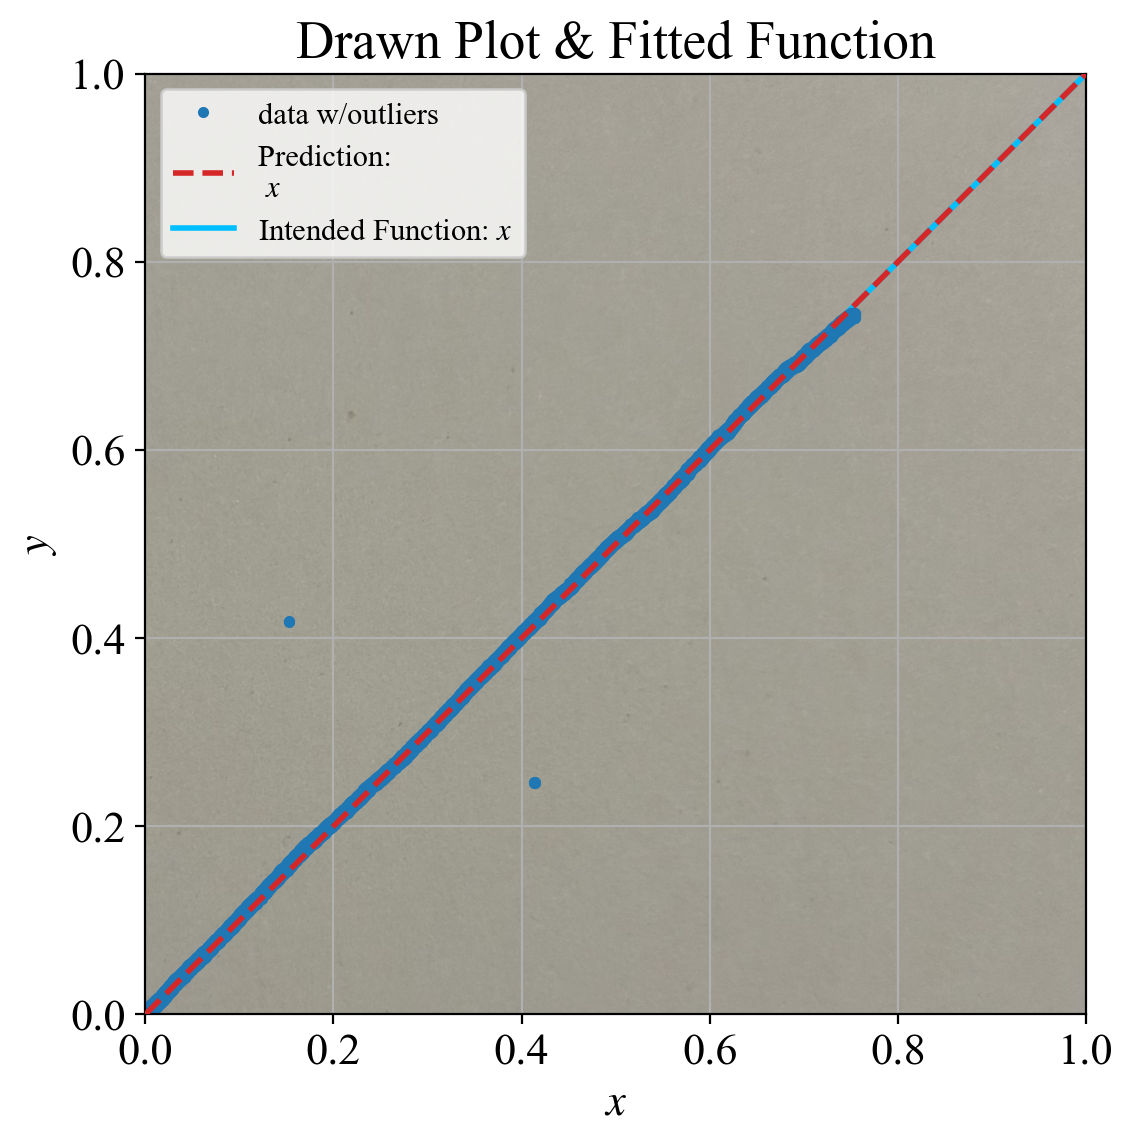

In [11]:
image_location=r"function_x.png"
image_fitter(image_location, model_path='function_x_model.joblib', use_saved=True, intd_expr='x',
             x_domain=[0,1], y_range=[0,1], show_cluster_outliers=True, show_clusters=False)

We can do it again, but this time only shown the data points that were chosen by DBSCAN as not being outliers for the fit.

Looking at file 'function_x.png'.
[[160 160 157 ... 167 168 169]
 [163 162 158 ... 165 166 166]
 [163 163 161 ... 164 164 163]
 ...
 [127 129 124 ... 157 155 154]
 [117 121 115 ... 159 159 157]
 [114 112 101 ... 160 161 159]]
Loaded pre-trained model from C:\Users\yagoi\Graduate Center Dropbox\Owen Root\Personal\College\12 Classes Spring 2025\Machine Learning\Final Project\\function_x_model.joblib
Best evolved expression: X0
LaTeX form: x


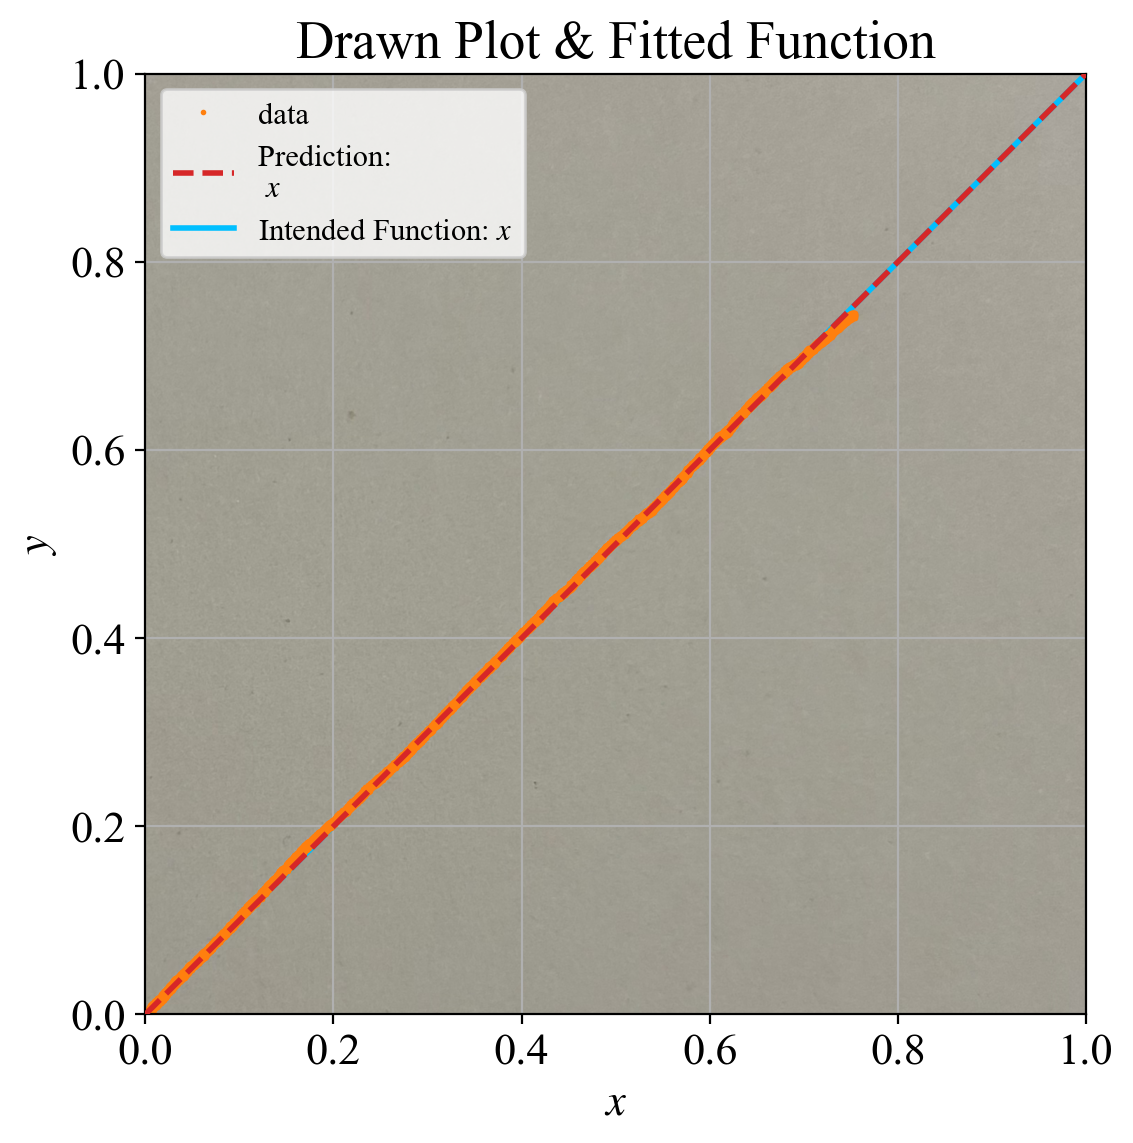

In [14]:
image_fitter(image_location, model_path='function_x_model.joblib', use_saved=True, intd_expr='x',
             x_domain=[0,1], y_range=[0,1], show_cluster_outliers=False, show_clusters=True)

Now lets try a slightly harder case, a drawing intended to show \sqrt{x}. Note that here, the given domain and range will strongly impact how close the drawn plot is to the intended function, \sqrt{x}. The ideal domain and range have been used.

Looking at file 'function_x^{.5}.png'.
[[175 174 172 ... 176 177 172]
 [167 168 172 ... 179 181 178]
 [167 167 172 ... 174 177 177]
 ...
 [158 157 149 ... 161 161 160]
 [158 158 151 ... 161 161 160]
 [155 153 146 ... 161 161 158]]
Loaded pre-trained model from C:\Users\yagoi\Graduate Center Dropbox\Owen Root\Personal\College\12 Classes Spring 2025\Machine Learning\Final Project\\function_x^{.5}_model.joblib
Best evolved expression: sqrt(X0)
LaTeX form: \sqrt{x}


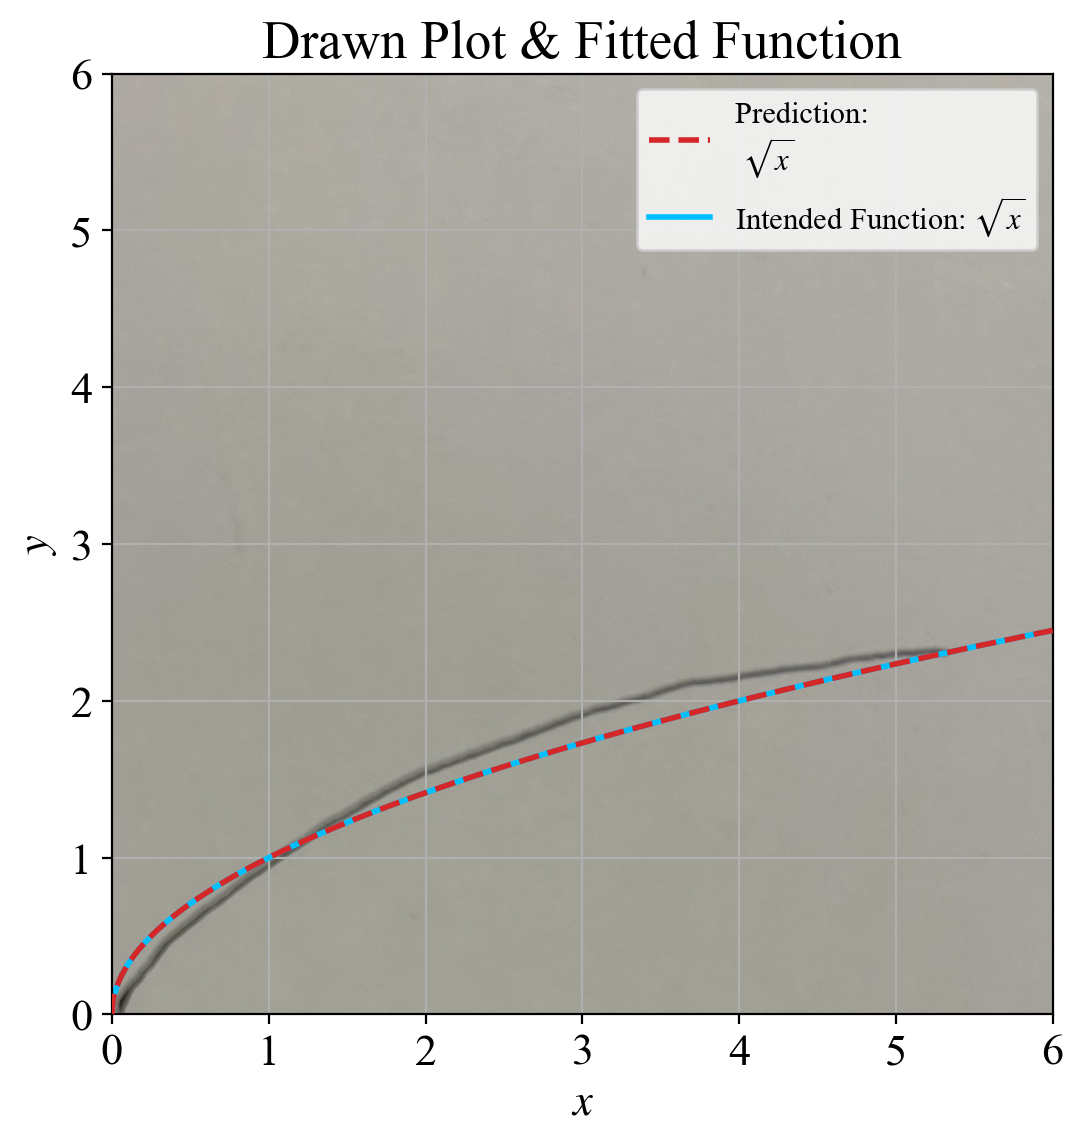

In [16]:
image_location=r"function_x^{.5}.png"
image_fitter(image_location, model_path='function_x^{.5}_model.joblib', use_saved=True, intd_expr='\sqrt{x}',
             x_domain=[0,6], y_range=[0,6], show_cluster_outliers=False, show_clusters=False)